### Windsat training   
Training notebook with windsat dataset, to experiment with model architecture, sample selection an hyperparameters.

In [1]:
import matplotlib.pyplot as plt
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
import sys
sys.path.append("../../")

from src.processing import windsat_datacube, model_preprocess
from src.model import transform_batch, xy_split, plot_history

In [40]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [21]:
# Preprocess and select the dataset
ascds = model_preprocess(ds)
ascds

<xarray.Dataset> Size: 784MB
Dimensions:         (day_number: 21, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

# Create the training dataset
Trust xarray and load all the data into a dataframe for training with keras


In [41]:
ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
ascds_df = transform_batch(ascds_df)
# Experimental: remove day number from training, It does not seem to have an effect on training (with 21 days)
# ascds_df.drop(columns = ["day_number"], inplace = True)
ascds_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
212694,0.017166,275.894440,-0.799947,0.959437,194.885010,127.485001,215.657501,163.107498,-0.498066,-0.498753
232835,0.017166,276.849609,-0.761821,0.932796,211.529999,159.434998,230.509995,191.927490,-0.502751,-0.503454
232838,0.017166,277.820099,-0.761821,0.937434,218.139999,172.832489,234.354996,200.334991,-0.502524,-0.503216
232839,0.017166,278.050476,-0.761821,0.938944,217.937500,172.014999,234.285004,199.912506,-0.502455,-0.503140
232840,0.017166,277.954346,-0.761821,0.940437,213.382492,163.179993,231.119995,193.644989,-0.502389,-0.503071
...,...,...,...,...,...,...,...,...,...,...
21661288,0.352752,276.515686,0.943368,0.376629,202.862488,140.917496,215.862503,169.722504,-0.745851,-0.746355
21661289,0.352752,275.758698,0.943368,0.380667,208.297485,151.820007,217.259995,175.607498,-0.745832,-0.746333
21705886,0.352752,275.418823,0.979487,0.201505,196.614990,127.227493,208.505005,153.690002,-0.752623,-0.753145
21705887,0.352752,275.177582,0.979487,0.205777,196.882492,127.707497,208.345001,153.547501,-0.752609,-0.753126


In [42]:
# Define a custom model to train:
def build_model():
    n_vars = ascds_df.shape[1] - 1 # dont count the prediction column.
    model = Sequential([
        Input((n_vars,)),
        BatchNormalization(),
        Dense(30,activation="linear", name = "hiddenLayer1"),
        Dense(20,activation="relu", name = "hiddenLayer2"),
        Dense(10,activation="relu", name = "hiddenLayer3"),
        Dense(1,activation="relu", name = "outputLayer")
    ])
    model.compile(
        optimizer = Adam(learning_rate = 0.014570815050621676 ),
        loss ="mse",
        metrics = ["mse"]
    )

    model.summary()

    return model

# best_params = {'n_neurons': 20, 'n_hidden': 1, 'learning_rate': 0.014570815050621676}

model =build_model()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

In [43]:
# Pick the columns for training and test
X, y = xy_split(ascds_df)
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)

# Fit the model
callback = EarlyStopping(
    monitor = "loss",
    patience = 3,
    min_delta = 0.1,
    verbose=2,
    restore_best_weights = True
)

checkpoints = ModelCheckpoint(
    filepath="../../models/checkpoint.weights.h5",
    save_weights_only= True,
    verbose = 1
)

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_test,y_test),
    callbacks=[callback, checkpoints]
)


Epoch 1/20
12487/12512 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1440.4528 - mse: 1440.4528
Epoch 1: saving model to ../../models/checkpoint.weights.h5
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 1437.9520 - mse: 1437.9520 - val_loss: 21.6616 - val_mse: 21.6616
Epoch 2/20
12490/12512 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 26.1984 - mse: 26.1984
Epoch 2: saving model to ../../models/checkpoint.weights.h5
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 26.1958 - mse: 26.1958 - val_loss: 18.0153 - val_mse: 18.0153
Epoch 3/20
12497/12512 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 22.1882 - mse: 22.1882
Epoch 3: saving model to ../../models/checkpoint.weights.h5
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 22.1875 - mse: 22.1875 - val_loss: 13.2124 - val_mse: 13.2124
Epoch 4/20
12465/12512 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 21.0950 - mse: 21.0950
Epoch 4: saving model to ../../models/checkpoint.weights.h5
12512/12512 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - 

In [44]:
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")

# Save FINAL model weights and history data.
model_path = f"../../models/{now}.keras"
save_model(model, model_path)

# Save training history
history_path = f"../../models/{now}_history"
with open(history_path,"wb") as hfile:
    pickle.dump(history.history, hfile)


(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: title={'center': 'Last 10 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

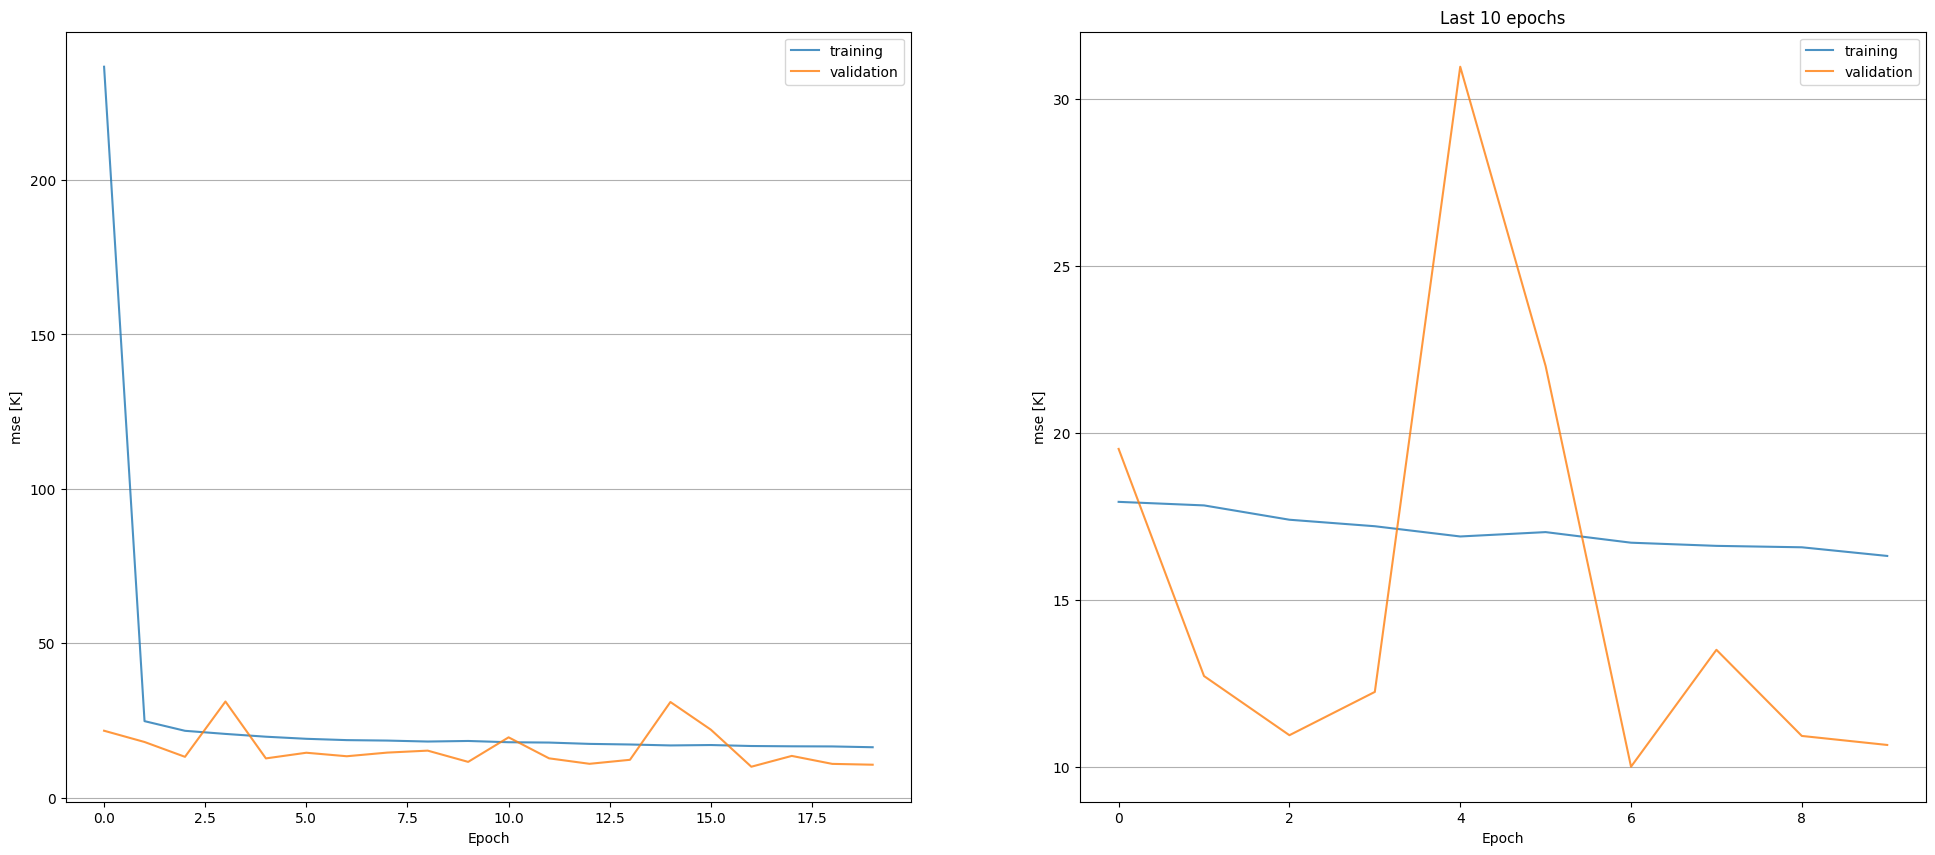

In [7]:
# Check the loading of the history file works
with open(history_path,"rb") as hfile:
    history = pickle.load(hfile)
    
plot_history(history)

# Notes

The model trains and the visualization is kind of nice. I need to run it with the full dataset.

My intuition is that we are not capturing the influence of day_number yet, since we only have 21 days (local dataset is biased)